# Turbofan Engine Degradation Simulation Data Set
## Golpira Elmi Assadzadeh, PhD

# Introduction

Significant operational costs can occur as a result of equipment failure. Unnecessary equipment downtime, possible safety hazards caused by non-working machines, and high turn around time which results in customer dissatisfaction can be avoided by proper maintenance strategies. 

There are three types of maintenance strategies: 

Preventive maintenance, where parts are replaced at certain set times (e.g, every six months). This may introduce unnecessary costs due to under utilizing the component.

Corrective maintenance, where parts are replaced when they fail. This can introduce costly downtimes, safety issues, or harm to other components of the machine.

Predictive maintenance, where a corrective and preventive maintenance meet. This can avoid under-utilization of components while conducting maintenance before failure.

This project aims to predict remaining useful life of turbofan engine based on previous failure data using machine learning methods. In order to conduct proper predictive maintenance analysis, it is important to carefully record historical data (including failure conditions) and that sufficient data is available to support the predictive analysis.

# Source Data
The dataset used for this project is part of the Prognostics Data Repository Collection provided by National Aeronautics and Space Administration (NASA) at https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan, and can be used for development of prognostic algorithms. The datasets contain multiple multivariate time series and is divided into training and test subsets. The training and test sets are stored in text files with columns separated by space. 

The training and test datasets used in this project each contain 100 turbofan engines of the same type that operate normally at the start of each cycle with some initial settings. At some point in time, these engines develop a fault which grows until system failure. For training dataset the last cycle is the cycle which the engine failed to operate. In the testset, the time series ends some time prior to system failure. The true remaining useful life of test data are provided in another text file. The objective of this project is to predict the number of remaining operational cycles before failure in the test set. There are 28 column of numbers corresponding to: 

1)	engine number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2

...

28)	sensor measurement  23

# Importing Required Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score

# Importing and Viewing Data

In [96]:
# Importing Data
url_training = 'https://raw.githubusercontent.com/golpiraelmi/Predictive-Maintenance/master/training_data.txt'
url_test = 'https://raw.githubusercontent.com/golpiraelmi/Predictive-Maintenance/master/test_data.txt'

# Names of the columns
cols=['engine','cycle', 'os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23']

# Importing training data
df_training=pd.read_csv(url_training, delimiter= ' ', names=cols)

# Importing test data
df_test= pd.read_csv(url_test, delimiter= ' ', names=cols)

### Viewing first few rows of training dataset

In [99]:
df_training.head()

,engine,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


### Viewing last few rows of test dataset

In [100]:
df_test.tail()

,engine,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN
13095,100,198,0.0013,0.0003,100.0,518.67,642.95,1601.62,1424.99,14.62,...,8214.64,8.4903,0.03,396,2388,100.0,38.70,23.1855,NaN,NaN


# Missing Values
### Dropping missing columns

In [101]:
# Dropping Missing Columns
df_training=df_training.dropna(axis=1)
df_test=df_test.dropna(axis=1)

### Check for missing values in other columns

In [102]:
# Check to see if there is any missing values in the rest of the dataset
print (df_training.isnull().values.any())
print (df_test.isnull().values.any())

False
False


There is no missing values in other columns.

# Data Statistics
Some basic statistical analysis can be obtained through following code.

In [103]:
# Statistical Analysis on the Training Data
df_training.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
os1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
os2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
os3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


# Dropping some columns

Sensors s1, s5, s6, s10, s16, s18, and s19 as well as os3 have similar minimum and maximum values. This indicates constant reading over experiment time, and should be removed from further analyses.

In [104]:
# Dropping Columns with flat sensor signals
df_training.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'os3'], axis=1, inplace=True)
df_test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'os3'], axis=1, inplace=True)

# Data Visualization

Variable histogram shows that most features show normal to log normal distribution. 

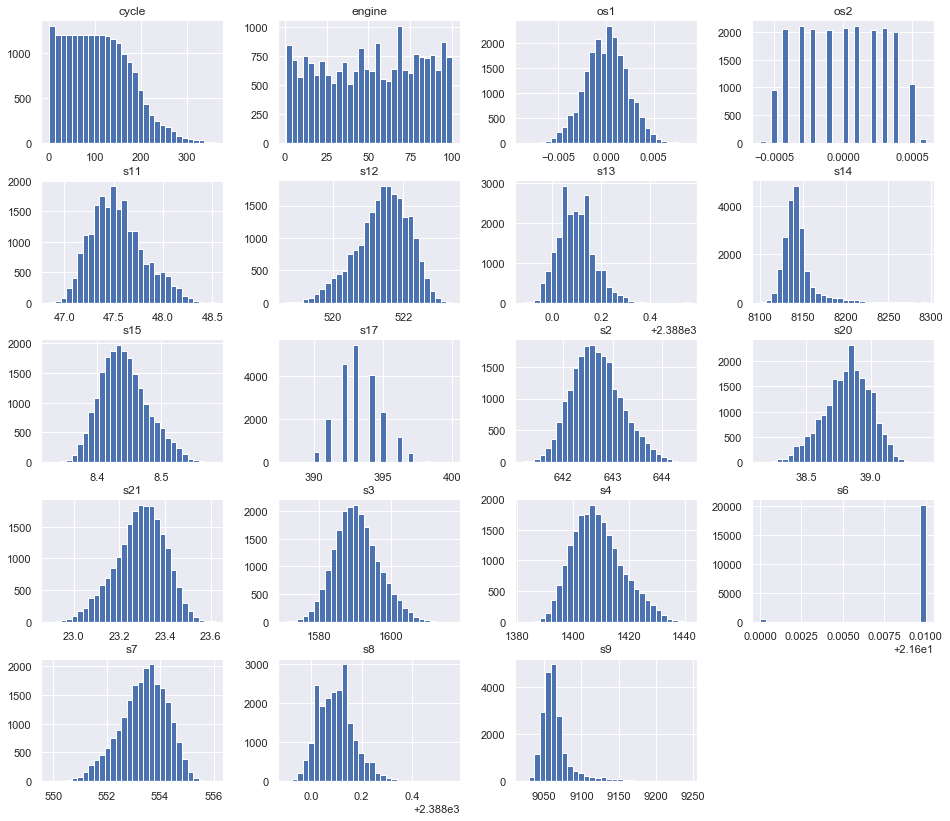

In [105]:
# Histogram of Variables in the Training Dataset
sns.set(font_scale=1) 
df_training.hist(bins=30, figsize=(16,14), color='b')

plt.show()

The barplot below shows the number of cycles for each engine before failure. Most engines age at least 150 cycles.

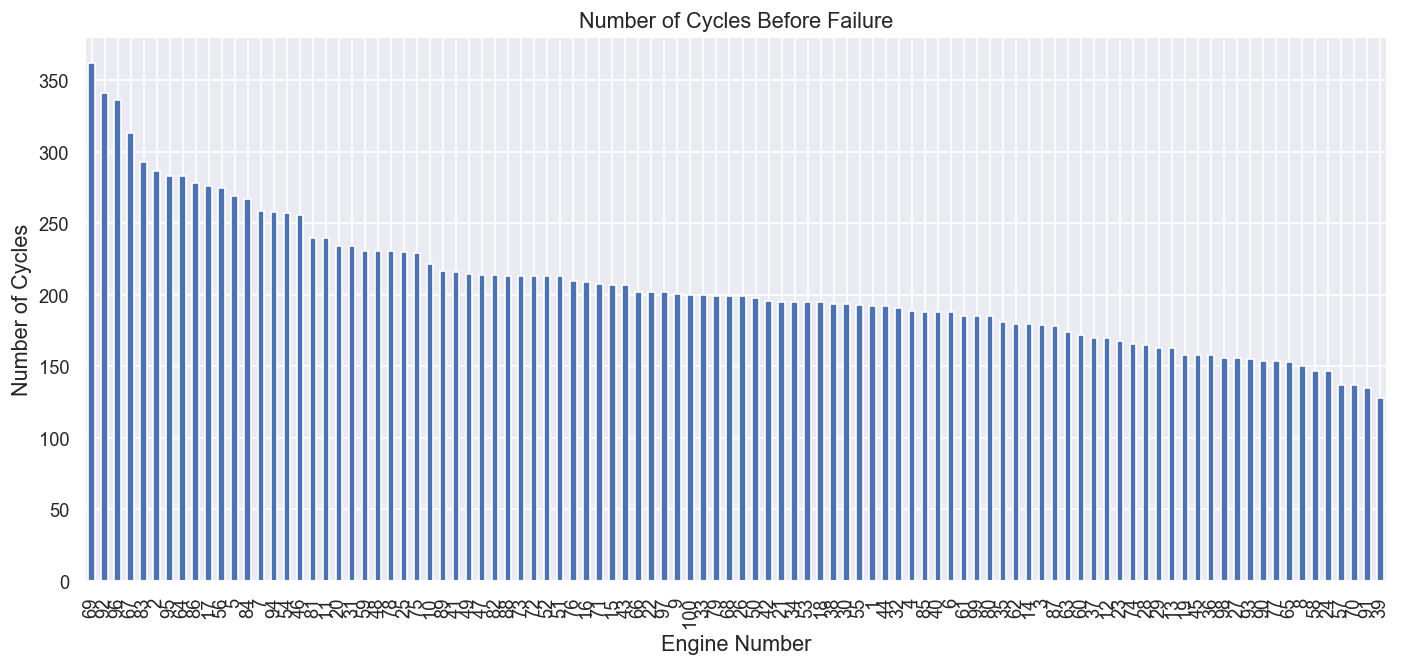

In [106]:
# Number of Cycles Before Failure for Each Engine

plt.figure(figsize=(14,6), dpi=120)
df_training.engine.value_counts().plot.bar()
plt.xlabel('Engine Number', fontsize=13)
plt.ylabel('Number of Cycles', fontsize=13)
plt.title('Number of Cycles Before Failure', fontsize=13)
plt.show()

The following plots show variations of specific sensors over time for sensor 9 and sensor 7

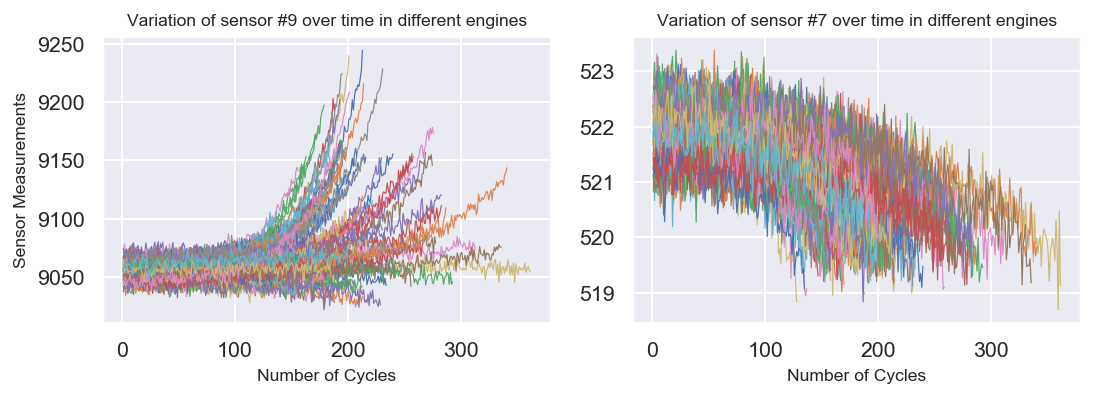

In [107]:
# Plotting Variation of specific sensors (sensor#9 and 7) for different engines.
fig = plt.figure(figsize = (8, 3), dpi=140)
sub1 = fig.add_subplot(121)
for i in pd.unique(df_training.engine):
    plt.plot(df_training[df_training.engine==i].cycle, df_training[df_training.engine==i].s9, linewidth=0.6)
plt.xlabel('Number of Cycles', fontsize=9)
plt.ylabel('Sensor Measurements', fontsize=9)
plt.title('Variation of sensor #9 over time in different engines', fontsize=9)

sub2 = fig.add_subplot(122)
for i in pd.unique(df_training.engine):
    plt.plot(df_training[df_training.engine==i].cycle, df_training[df_training.engine==i].s12, linewidth=0.6)
plt.xlabel('Number of Cycles', fontsize=9)

plt.title('Variation of sensor #7 over time in different engines', fontsize=9)
plt.tight_layout()
plt.show()

The following plots show how sensor values change over time (cycles). Only a few sensors are included in the plot. The rest of sensors show similar trends.

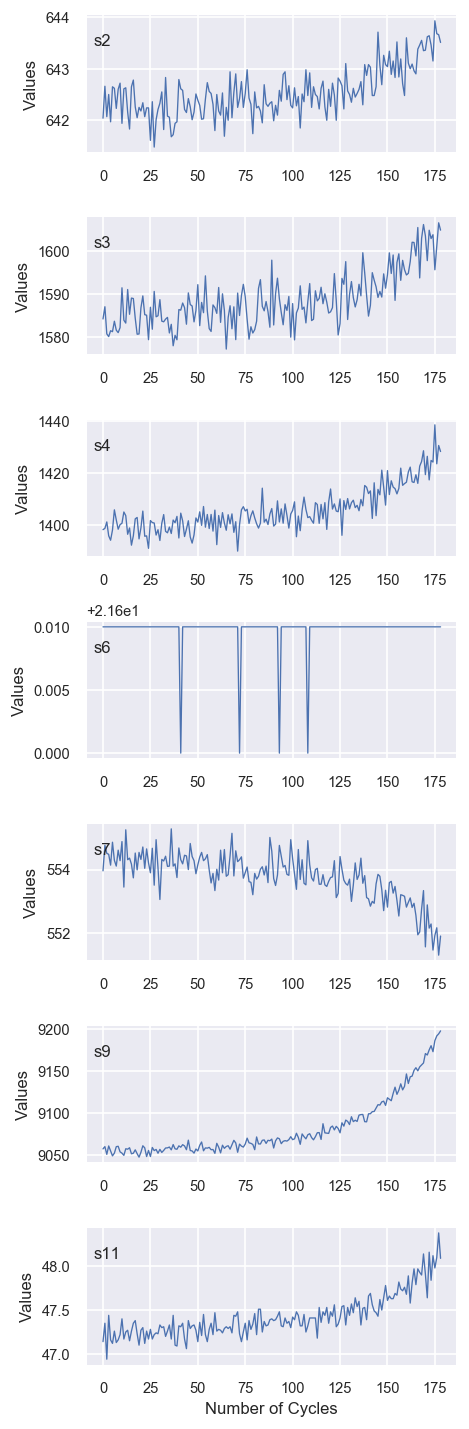

In [108]:
# Plotting sensor values for an engine #3
sensor_values = df_training[df_training.engine==3].values
sensors_to_plot = [4, 5, 6, 7, 8, 10, 11]
i = 1
sns.set(font_scale=0.8) 
plt.figure(figsize=(4,12), dpi=120)


for s in sensors_to_plot:
    


    plt.subplot(len(sensors_to_plot), 1, i)
    plt.plot(sensor_values[:, s], color='b', linewidth=0.8)
    plt.title(df_training.columns[s], y=0.7, x=0.02, loc='left', fontsize=10)
    i += 1
    plt.ylabel('Values', fontsize=10)
plt.xlabel('Number of Cycles', fontsize=10)
plt.tight_layout()
plt.show()

As shown in the figure above the values for some sensore have similar trend. This can adversely affect the accuracy of machine learning algorithms. The heatmap plot of correlations among various sensors is plotted to help decide which features are highly correlated to one another and should be removed from predictive analysis.

# Correlation Between Sensors

In [109]:
df_features = df_training.drop(['engine','cycle','os1', 'os2'], axis=1)

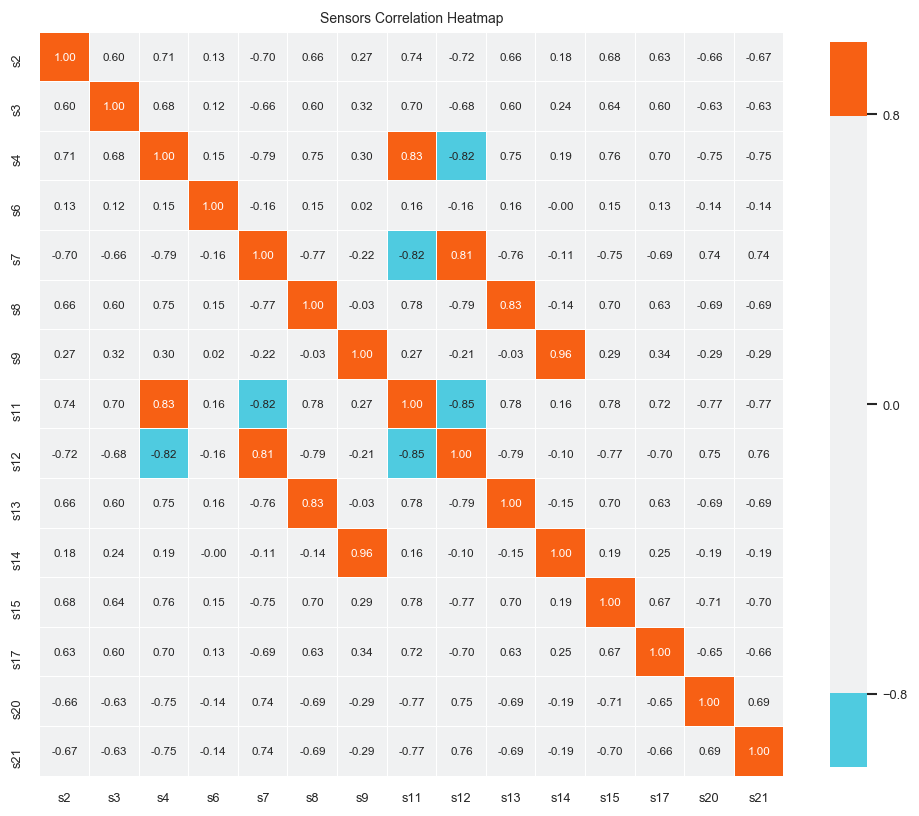

In [110]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(10,10), dpi=120)
sns.set(font_scale=0.7)
ax= sns.heatmap(df_features.corr(), fmt= '.2f', vmin=-1, vmax=1, center=0, linewidths=.01,
    cmap=ListedColormap(['#4fcbe0', '#f0f1f2', '#f0f1f2', '#f0f1f2', '#f0f1f2','#f0f1f2','#f0f1f2','#f0f1f2','#f0f1f2','#f76014']),
    square=True, annot=True, annot_kws={'size': 7}, cbar_kws={"shrink": 0.8, 'ticks':[-0.8, 0, 0.8]})
bottom, top = ax.get_ylim()
plt.title('Sensors Correlation Heatmap')
plt.show()

The correlation plot shows strong correlation (correlation > 80%) among sensors (s4, s11), (s7, s12) (s8, s13), (s9, s14), (s4, s12), (s7,s11), and (s11, s12). Strongly correated variables adversely affect machine learning predictions. 

# Feature Engineering

### Removing strongly correlated features
In addition to removing sensors with flat signals, some of the correlated sensors must also be removed to enhance machine learning performance. Variations in sensors s11, s8, and s9, can explain variations in s4, s7, s12, s13, and s14, so sensors s4, s7, s12, s13 have been removed. Sensors s2, s3, s8, s9, s11, s15, s17, s20, s21 have been kept for further analysis.

### Calculating Time-to-Failure (TTF)
In order to predict the number of remaining operational cycles before failure, a time to failure (TTF) column is defined as the length of time a device is expected to operate before it fails. The TTF is used to evaluate the reliability of pieces of hardware.

For training dataset TTF is calculated by deducting the current cycle from the maximum cycle (cycle at which failure had occurred) for each engine.

For the test dataset, the last cycle is not the 'failed' cycle, and the remaining useful life (RUL) of engine is provided in a separate textfile. Therefore, for the purpose of this project the last cycle in the testset is merged with the RUL data.

### Data Scaling
Scaling data is an important step before predictive analysis as it allows all sensors to have similar range.

The following function (prepare_data) is defined to prepare data for both training and test datasets.

In [114]:
def prepare_data(df_input):

    # Importing RUL dataset (to be merged with the test set    
    url_RUL = 'https://raw.githubusercontent.com/golpiraelmi/Predictive-Maintenance/master/RUL.txt'
    df_RUL = pd.read_csv(url_RUL, sep= ' ', header=None)
    df_RUL=df_RUL.dropna(axis=1)
    df_RUL.columns = ['TTF']
    
    # creating an empty dataframe for storing final results
    df_output = pd.DataFrame() 

    # Groupping similar engine units
    for i in pd.unique(df_input.engine):
    
        # Creating a dataframe for each engine
        df_engine = df_input[df_input['engine'] == i]
        
        # If input file is the training dataset, we calculate TTF.
        if df_input.equals(df_training):
            # Calculates TTF for each engine
            df_engine_ttf = df_engine.cycle.max() - df_engine.cycle
            df_engine_ttf=pd.DataFrame(df_engine_ttf)
            df_engine_ttf.columns=['TTF']
            
            # Merge the calculated TTF dataframe, to engines dataframe
            df_ttf = pd.concat([df_engine, df_engine_ttf], axis=1)
    
            # Merge data for each engine to create one dataframe containing all engines
            df_output = pd.concat([df_output,df_ttf])
        
            # Filter out the rows with TTF=0 (failed cycles)
            ttf_is_not_zero = df_output['TTF']!=0
            df_output = df_output[ttf_is_not_zero]
            
            # Keeping only columns required for machine learning
            df_output = df_output[['engine','cycle','os1', 'os2', 's2', 's3', 's8', 's9', 's11', 's15', 's17', 's20', 's21','TTF']]
    ####################################     
        # If the input file is test set, we'll merge it with RUL data
        elif df_input.equals(df_test):
    
            # Merge data for each engine to create one dataframe containing all engines
            df_output = pd.concat([df_output, df_engine])
            
            # Dropping raw sensor data (keeping avgs columns)
            df_output = df_output[['engine','cycle','os1', 'os2', 's2', 's3', 's8', 's9', 's11', 's15', 's17', 's20', 's21']]

            
            #Finding the rows with maximum cycle number in the testset
            testset_max_cycle = pd.DataFrame(df_output.groupby('engine').cycle.max())

            df_output = pd.merge(df_output,testset_max_cycle, on='engine') 

            df_output = df_output[df_output['cycle_x'] == df_output['cycle_y']]
            df_output.drop(['cycle_y'], axis=1, inplace=True)
            df_output.reset_index(drop=True, inplace=True)
            df_output.rename(columns = {'cycle_x':'cycle'}, inplace = True) 
            df_output=pd.concat([df_output,df_RUL], axis=1)
    df_output[['engine','cycle']] = df_output[['engine','cycle']].astype('int32')
            
    # Scaling data for both training and test sets
    scaler = MinMaxScaler()
    df_output.iloc[:,2:13] = scaler.fit_transform(df_output.iloc[:,2:13])
    
    return df_output

By passing the raw training and test data into prepare_data function, we'll have datasets ready for prognostic analysis. The prepared data are called trainset and testset.

In [115]:
trainset = prepare_data(df_training)

In [116]:
trainset

,engine,cycle,os1,os2,s2,s3,s8,s9,s11,s15,s17,s20,s21,TTF
0,1,1,0.459770,0.166667,0.183735,0.406802,0.285714,0.119393,0.380368,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.250000,0.109045,0.392638,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.321429,0.152341,0.257669,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.375000,0.135452,0.171779,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.285714,0.163128,0.263804,0.402078,0.416667,0.589147,0.704502,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,100,195,0.488506,0.416667,0.662651,0.632221,0.589286,0.234100,0.840491,0.873413,0.500000,0.000000,0.411627,5
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.517857,0.213745,0.748466,0.656791,0.750000,0.271318,0.109500,4
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.589286,0.211744,0.730061,0.727203,0.583333,0.124031,0.366197,3
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.607143,0.215600,0.760736,0.922278,0.833333,0.232558,0.053991,2


In [117]:
testset = prepare_data(df_test)

In [119]:
testset

,engine,cycle,os1,os2,s2,s3,s8,s9,s11,s15,s17,s20,s21,TTF
0,1,31,0.392593,0.9,0.364035,0.140105,0.300000,0.230295,0.142857,0.191225,0.428571,0.547619,0.698312,112
1,2,49,0.570370,0.4,0.350877,0.315480,0.366667,0.139535,0.561905,0.506221,0.142857,0.547619,0.501266,98
2,3,126,0.318519,0.9,0.495614,0.418681,0.566667,0.174575,0.761905,0.253438,0.714286,0.690476,0.527004,69
3,4,106,0.525926,0.9,0.451754,0.574788,0.466667,0.190495,0.542857,0.590701,0.714286,0.273810,0.493460,82
4,5,98,0.340741,0.1,0.228070,0.424886,0.366667,0.211487,0.361905,0.412574,0.571429,0.476190,0.817511,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,0.392593,0.8,0.241228,0.455585,0.133333,0.277197,0.057143,0.247544,0.142857,0.726190,0.920675,137
96,97,134,0.533333,0.4,0.368421,0.196930,0.233333,0.386062,0.285714,0.502947,0.714286,0.309524,0.571941,82
97,98,121,0.562963,0.6,0.407895,0.737427,0.466667,0.276651,0.552381,0.329404,0.571429,0.488095,0.710127,59
98,99,97,0.785185,0.5,0.109649,0.264533,0.066667,0.314266,0.171429,0.177472,0.142857,0.714286,0.707384,117


# Prognostic Analysis

In the following, several machine learning algorithms are built to predict TTF and are compared to one another.

In [120]:
X_train = trainset.values[:,1:12]
Y_train = trainset.values[:,13].astype('int32')
X_test = testset.values[:,1:12]
Y_test = testset.values[:,13].astype('int32')

In [121]:
Y_train

array([191, 190, 189, ...,   3,   2,   1], dtype=int32)

In [122]:
Y_test

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int32)

# Simple Regression Model

In [123]:
# Fitting linear regression model on training dataset
lm = LinearRegression()
model_lm = lm.fit(X_train,Y_train)
model_lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [127]:
# Predicting TTF using testset
Y_hat_LR = lm.predict(X_test)

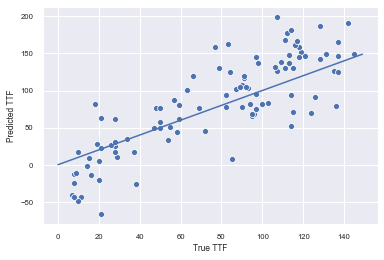

In [128]:
# Plotting Predicted TTF and True TTF
sns.scatterplot(Y_test, Y_hat_LR)
plt.xlabel('True TTF')
plt.ylabel('Predicted TTF')
plt.plot(range(0,150),range(0,150))
plt.show()

In [129]:
# Calculating scoring parameters
print('RMSE:', '{:.2f}'. format(metrics.mean_squared_error(Y_test, Y_hat_LR)**0.5))
print("Mean absolute error: %.2f" % np.mean(np.absolute(Y_hat_LR - Y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((Y_hat_LR - Y_test) ** 2))
print("R2-score: %.2f" % r2_score(Y_hat_LR , Y_test) )

RMSE: 36.54
Mean absolute error: 29.30
Residual sum of squares (MSE): 1334.98
R2-score: 0.66


# Polynomial Regression Model (Degree 2)

In [135]:
# Fitting model on training dataset
poly2 = PolynomialFeatures(degree=2)
train_x_poly2 = poly2.fit_transform(X_train)
clf2 = linear_model.LinearRegression()
clf2.fit(train_x_poly2, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [133]:
# The coefficients
print ('Coefficients: ', clf2.coef_)
print ('Intercept: ',clf2.intercept_)

Coefficients:  [-4.62654553e-10 -7.64965805e-01  2.61068212e+01 -4.72581735e+00
 -5.83040647e+01 -5.06069985e+01 -9.63091439e+01 -3.45345429e+02
 -5.45264405e+00 -7.09871158e+01 -4.14579754e+01  8.51365682e+01
  3.75766981e-03 -6.01479672e-02 -1.50387164e-02 -7.92353992e-02
 -6.74165420e-02 -3.87422881e-01 -2.84350365e-01 -3.88222762e-01
 -2.47886526e-01 -7.72589673e-02  1.63822141e-01 -6.40693893e+00
 -7.59988097e+00  3.82752176e+01  1.27985480e+01 -5.05253998e+00
  3.05524802e+01 -5.58828096e+01  2.43663646e+01 -1.45410101e+01
 -3.50513591e+01  2.54750693e-01  6.49697022e+00  7.60630685e+00
 -2.53198502e+01  1.67034069e+00  7.70616272e+00  6.58270089e+00
 -5.94865786e+00  1.87130715e+01  1.14309617e+01 -4.60006791e+01
 -3.00354106e+01  5.78086873e+01  3.48213795e+01  4.01212028e+00
  2.52639507e+01 -2.39369402e+00 -2.47607064e+00  6.37677854e+01
  6.41880311e+01 -1.03505413e+01  7.74100179e+01 -3.94815896e+01
 -6.89149393e-01 -4.75448645e+01  1.48613968e+02  5.93655737e+01
  4.342601

In [134]:
# Predicting TTF using testset and calculating scoring parameters
test_x_poly2 = poly2.fit_transform(X_test)
Y_hat2 = clf2.predict(test_x_poly2)
print('RMSE:', '{:.2f}'. format(metrics.mean_squared_error(Y_test, Y_hat2)**0.5))
print("Mean absolute error: %.2f" % np.mean(np.absolute(Y_hat2 - Y_test)))
print("Mean squared error (MSE): %.2f" % np.mean((Y_hat2 - Y_test) ** 2))
print("R2-score: %.2f" % r2_score(Y_hat2 , Y_test) )

RMSE: 33.04
Mean absolute error: 26.95
Mean squared error (MSE): 1091.42
R2-score: 0.69


# Polynomial Regression Model (Degree 3)

In [137]:
# Fitting model on training dataset
poly3 = PolynomialFeatures(degree=3)
train_x_poly3 = poly3.fit_transform(X_train)
clf3 = linear_model.LinearRegression()
clf3.fit(train_x_poly3, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [138]:
# The coefficients
print ('Coefficients: ', clf3.coef_)
print ('Intercept: ',clf3.intercept_)

Coefficients:  [-1.79328070e-05 -6.08649602e-01 -7.41163524e+01  5.39506985e+01
 -1.43057538e+02 -8.12028496e+01 -8.62703518e+02 -1.09427100e+03
  7.34283898e+02 -9.97360256e+01 -9.44229901e+01 -1.87870090e+01
  7.26485556e-03 -6.77563323e-01 -1.85802068e-01 -3.20229906e-01
 -9.49333744e-02 -5.98502830e-01 -5.33586876e-01 -6.20659102e-01
  1.38886518e-01 -1.15540577e+00  2.97675079e-01  5.37051054e+02
 -1.43863468e+02  6.75963623e+01 -1.26405755e+02  7.90588185e+02
  2.55603930e+02 -1.14358351e+03  7.93904844e+01  3.95458816e+02
 -4.84545127e+02 -1.36060382e+02  2.82541049e+01 -9.05640100e+01
 -2.14843967e+02  4.80306673e+01  1.76719973e+02  1.05576671e+02
  1.34590135e+02  1.24657706e+01 -5.03992301e+01  2.07910422e+02
 -3.16911681e+02  3.92121973e+02 -3.55253244e+02 -1.68548719e+02
  7.40963811e+02  1.14956150e+02 -4.97681577e+02  1.01728040e+03
  5.62204799e+02 -4.38840516e+02  2.20958792e+02  1.67943586e+02
  1.74935798e+02  3.18634564e+02  1.09623844e+03 -6.62107496e+02
  2.903837

In [139]:
# Predicting TTF using testset and calculating scoring parameters
test_x_poly3 = poly3.fit_transform(X_test)
Y_hat3 = clf3.predict(test_x_poly3)
print('RMSE:', '{:.2f}'. format(metrics.mean_squared_error(Y_test, Y_hat3)**0.5))
print("Mean absolute error: %.2f" % np.mean(np.absolute(Y_hat3 - Y_test)))
print("Mean squared error (MSE): %.2f" % np.mean((Y_hat3 - Y_test) ** 2))
print("R2-score: %.2f" % r2_score(Y_hat3 , Y_test) )

RMSE: 32.48
Mean absolute error: 26.82
Mean squared error (MSE): 1054.69
R2-score: 0.67


# References:
A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA

Azure AI guide for predictive maintenance solutions:
https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/predictive-maintenance-playbook#modeling-techniques-for-predictive-maintenance